# Preprocess 

- load the fluxnet dataset and aggregate to daily intervals 

TODO: 
1. Fix the null/default negative values in the dataset [done]
2. Revert the copying of hr datasets [done]
3. Set up evaluation to do cross validation 

In [1]:
!mamba install -y -c conda-forge python-snappy openpyxl intake-parquet


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.2) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['python-snappy', 'openpyxl', 'intake-parquet']

pkgs/main/linux-64       [=>                  ] (--

In [2]:
# %load_ext lab_black

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client

import fsspec

from met_ml.data import cat
from met_ml.train.fluxnet_etl import load_fluxnet, get_meta
from met_ml.train.features import make_lookback


FOLDER = '/home/jovyan/met-ml/data/'

In [4]:
client = Client(n_workers=2)
client

Client Scheduler: tcp://127.0.0.1:46785 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 32.14 GB


In [5]:
# TODO: put this dataset in cat
# also, there may be a new version of this...?

all_site_meta = pd.read_excel("../met_ml/data/FLX_AA-Flx_BIF_LATEST.xlsx").set_index(
    ["SITE_ID", "VARIABLE"]
)["DATAVALUE"]

all_site_meta.head()

SITE_ID  VARIABLE            
AR-SLu   MAP                                      400
         COUNTRY                            Argentina
         DOI                     10.18140/FLX/1440191
         DOI_DATAPRODUCT                  FLUXNET2015
         DOI_CONTRIBUTOR_NAME       Patricio Magliano
Name: DATAVALUE, dtype: object

In [18]:
df = load_fluxnet(cat, all_site_meta)

getting meta data
getting all jobs
computing
prep output
failed to read AU-Tum, look into this...
failed to read BR-Sa1, look into this...
failed to read DK-NuF, look into this...
failed to read DK-ZaF, look into this...
failed to read DK-ZaH, look into this...
failed to read FI-Lom, look into this...
failed to read NO-Adv, look into this...
failed to read NO-Blv, look into this...
failed to read RU-Sam, look into this...
failed to read RU-SkP, look into this...
failed to read RU-Tks, look into this...
failed to read RU-Vrk, look into this...
failed to read SE-St1, look into this...
failed to read US-Cop, look into this...
failed to read US-Ha1, look into this...
failed to read US-MMS, look into this...
failed to read US-Ne1, look into this...
failed to read US-Ne2, look into this...
failed to read US-Ne3, look into this...
failed to read US-PFa, look into this...
failed to read US-UMB, look into this...
failed to read ZA-Kru, look into this...
concat


In [19]:
df.head()

precip  t_min  t_max  SW_IN_F_MDS  LW_IN_F_MDS  PA  \
Site   TIMESTAMP_START                                                       
AR-SLu 2009-01-01          0.0    NaN    NaN   281.068438          NaN NaN   
       2009-01-02          0.0    NaN    NaN   279.302521          NaN NaN   
       2009-01-03          0.0    NaN    NaN   271.058333          NaN NaN   
       2009-01-04          0.0    NaN    NaN   281.068438          NaN NaN   
       2009-01-05          0.0    NaN    NaN   279.302521          NaN NaN   

                        RH   SW_IN_ERA   LW_IN_ERA     PA_ERA     RH_ERA  doy  \
Site   TIMESTAMP_START                                                          
AR-SLu 2009-01-01      NaN   79.239667  380.892000  95.294625  78.419485    1   
       2009-01-02      NaN  254.912292  369.231500  95.597354  70.699586    2   
       2009-01-03      NaN  342.819187  346.828625  95.650583  60.222468    3   
       2009-01-04      NaN  410.918083  338.023500  95.272437  47.954900    4   
       2009-01-05      NaN  306.377375  367.396125  94.955813  48.604656    5   

                            lat      lon   elev  
Site   TIMESTAMP_START                           
AR-SLu 2009-01-01      -33.4648 -66.4598  508.0  
       2009-01-02      -33.4648 -66.4598  508.0  
       2009-01-03      -33.4648 -66.4598  508.0  
       2009-01-04      -33.4648 -66.4598  508.0  
       2009-01-05      -33.4648 -66.4598  508.0

In [20]:
df.count()

precip         469351
t_min          443122
t_max          443122
SW_IN_F_MDS    447758
LW_IN_F_MDS    276153
PA             329268
RH             392470
SW_IN_ERA      469351
LW_IN_ERA      469351
PA_ERA         469351
RH_ERA         469351
doy            469351
lat            469351
lon            469351
elev           469351
dtype: int64

In [21]:
df.describe()

,precip,t_min,t_max,SW_IN_F_MDS,LW_IN_F_MDS,PA,RH,SW_IN_ERA,LW_IN_ERA,PA_ERA,RH_ERA,doy,lat,lon,elev
count,469351.000000,443122.000000,443122.000000,447758.000000,276153.000000,329268.000000,392470.000000,469351.000000,469351.000000,469351.000000,469351.000000,469351.000000,469351.000000,469351.000000,469351.000000
mean,1.647761,5.711337,14.709931,160.886844,312.810215,95.672536,71.517793,159.264918,310.584328,95.048147,69.262603,183.127107,39.244455,-17.374406,571.753554
std,5.911234,10.855096,12.200815,102.199245,56.660552,6.395067,19.196732,96.341378,55.747870,7.371297,18.697526,105.439826,22.222895,77.104116,709.257994
min,0.000000,-49.870000,-47.520000,0.000000,104.493417,70.000000,1.654000,0.000000,96.774875,59.154937,-250.580721,1.000000,-37.425900,-157.408900,-9.000000
25%,0.000000,-0.300000,6.634000,69.889010,277.725000,93.854760,60.663714,75.117156,275.523125,93.128635,59.339490,92.000000,38.431600,-90.079900,124.000000
50%,0.000000,6.655000,15.610000,153.808000,314.539437,98.062021,75.046312,157.616042,313.179167,97.730604,72.458639,183.000000,45.562500,5.998080,270.000000
75%,0.254000,13.029000,23.740000,244.110365,349.963125,100.071436,86.009750,237.759052,346.805750,99.927312,82.781983,274.000000,50.893060,13.565160,705.000000
max,424.400000,31.550000,46.260000,431.894417,479.520833,105.485667,100.000000,418.973688,465.642146,106.376437,100.000000,366.000000,70.829140,161.341430,4313.000000


In [ ]:
(df.RH_ERA < 0).mean()

In [22]:
df.isnull().mean()

precip         0.000000
t_min          0.055884
t_max          0.055884
SW_IN_F_MDS    0.046006
LW_IN_F_MDS    0.411628
PA             0.298461
RH             0.163803
SW_IN_ERA      0.000000
LW_IN_ERA      0.000000
PA_ERA         0.000000
RH_ERA         0.000000
doy            0.000000
lat            0.000000
lon            0.000000
elev           0.000000
dtype: float64

In [23]:
for site, sub_df in df.groupby('Site'):
    print(site)
    print('LW_IN_F_MDS: ', sub_df.LW_IN_F_MDS.isnull().mean())
    print('PA: ', sub_df.PA.isnull().mean())
    print('RH: ', sub_df.RH.isnull().mean())

AR-SLu
LW_IN_F_MDS:  1.0
PA:  0.582648401826484
RH:  0.582648401826484
AR-Vir
LW_IN_F_MDS:  1.0
PA:  0.460643394934976
RH:  0.45927446954141
AT-Neu
LW_IN_F_MDS:  0.359880537580886
PA:  0.47834743653558986
RH:  0.021901443504230962
AU-Ade
LW_IN_F_MDS:  0.4516423357664234
PA:  0.48996350364963503
RH:  0.48996350364963503
AU-ASM
LW_IN_F_MDS:  0.1254107338444688
PA:  0.13526834611171962
RH:  0.13526834611171962
AU-Cpr
LW_IN_F_MDS:  0.10733844468784227
PA:  0.17853231106243153
RH:  0.17031763417305587
AU-Cum
LW_IN_F_MDS:  0.2518248175182482
PA:  0.2655109489051095
RH:  0.2655109489051095
AU-DaP
LW_IN_F_MDS:  0.13453265545561205
PA:  0.208056315995307
RH:  0.167774736018772
AU-DaS
LW_IN_F_MDS:  0.0
PA:  0.02972233085647243
RH:  0.012123582323034806
AU-Dry
LW_IN_F_MDS:  0.08916699256941729
PA:  0.31443097379741886
RH:  0.281971059835745
AU-Emr
LW_IN_F_MDS:  0.1322992700729927
PA:  0.17335766423357665
RH:  0.17244525547445255
AU-Fog
LW_IN_F_MDS:  0.06113138686131387
PA:  0.1259124087591241
RH:

In [24]:
def plot_vars(df):
    fig, axes = plt.subplots(
        ncols=len(df.columns), nrows=1, sharex=True, figsize=(22, 4)
    )

    for ax, (key, s) in zip(axes, df.items()):
        s.plot(ax=ax)
        ax.set_title(key)
        
    plt.show()
    plt.close()

features


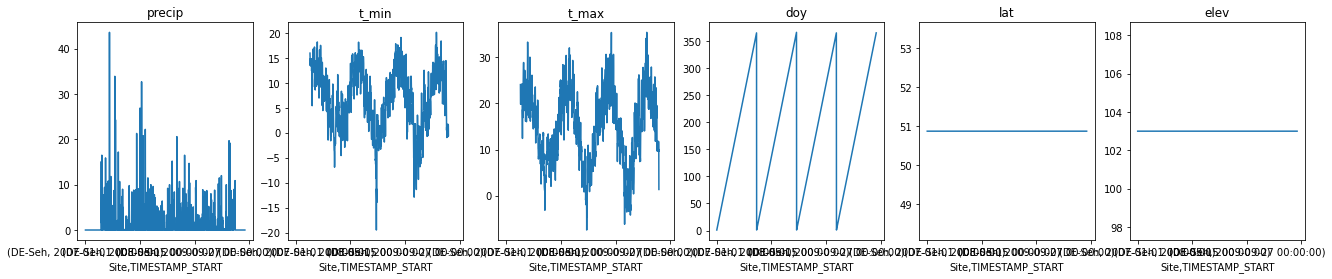

labels


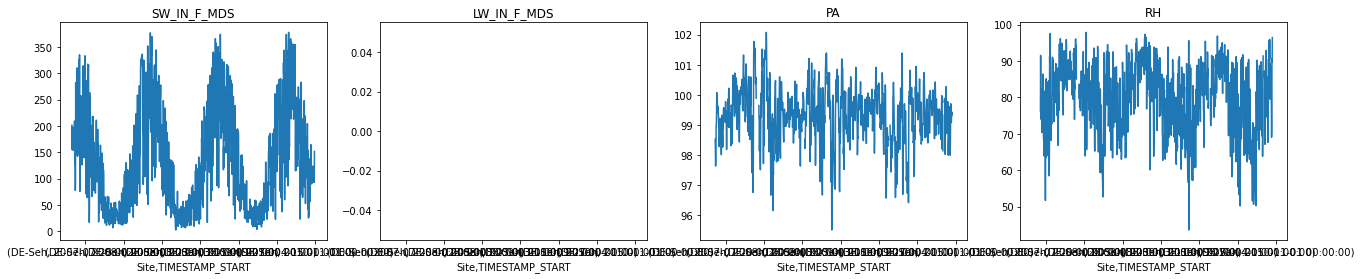

In [25]:
train_vars = ["precip", "t_min", "t_max", "doy", "lat", "elev"]
target_vars = ["SW_IN_F_MDS", "LW_IN_F_MDS", "PA", 'RH']

all_sites = df.index.get_level_values('Site').unique()
site = all_sites[random.randint(0, len(all_sites))]
print('features')
plot_vars(df.loc[df.index.get_level_values('Site') == site, train_vars])
print('labels')
plot_vars(df.loc[df.index.get_level_values('Site') == site, target_vars])

In [26]:
df.rename(columns={'SW_IN_F_MDS': 'SW_IN', 'LW_IN_F_MDS': 'LW_IN'}, inplace=True)

In [27]:
df

precip  t_min  t_max       SW_IN  LW_IN  PA  RH  \
Site   TIMESTAMP_START                                                    
AR-SLu 2009-01-01          0.0    NaN    NaN  281.068438    NaN NaN NaN   
       2009-01-02          0.0    NaN    NaN  279.302521    NaN NaN NaN   
       2009-01-03          0.0    NaN    NaN  271.058333    NaN NaN NaN   
       2009-01-04          0.0    NaN    NaN  281.068438    NaN NaN NaN   
       2009-01-05          0.0    NaN    NaN  279.302521    NaN NaN NaN   
...                        ...    ...    ...         ...    ...  ..  ..   
ZM-Mon 2009-12-27          0.0    NaN    NaN         NaN    NaN NaN NaN   
       2009-12-28          0.0    NaN    NaN         NaN    NaN NaN NaN   
       2009-12-29          0.0    NaN    NaN         NaN    NaN NaN NaN   
       2009-12-30          0.0    NaN    NaN         NaN    NaN NaN NaN   
       2009-12-31          0.0    NaN    NaN         NaN    NaN NaN NaN   

                         SW_IN_ERA   LW_IN_ERA     PA_ERA     RH_ERA  doy  \
Site   TIMESTAMP_START                                                      
AR-SLu 2009-01-01        79.239667  380.892000  95.294625  78.419485    1   
       2009-01-02       254.912292  369.231500  95.597354  70.699586    2   
       2009-01-03       342.819187  346.828625  95.650583  60.222468    3   
       2009-01-04       410.918083  338.023500  95.272437  47.954900    4   
       2009-01-05       306.377375  367.396125  94.955813  48.604656    5   
...                            ...         ...        ...        ...  ...   
ZM-Mon 2009-12-27       291.147063  375.189667  89.212104  74.208103  361   
       2009-12-28       271.966271  381.716292  89.171292  76.592744  362   
       2009-12-29       241.666313  381.685042  89.142167  82.413293  363   
       2009-12-30       234.093354  384.903333  89.143312  77.911396  364   
       2009-12-31       181.601562  392.126125  89.211792  81.654115  365   

                             lat       lon    elev  
Site   TIMESTAMP_START                              
AR-SLu 2009-01-01      -33.46480 -66.45980   508.0  
       2009-01-02      -33.46480 -66.45980   508.0  
       2009-01-03      -33.46480 -66.45980   508.0  
       2009-01-04      -33.46480 -66.45980   508.0  
       2009-01-05      -33.46480 -66.45980   508.0  
...                          ...       ...     ...  
ZM-Mon 2009-12-27      -15.43778  23.25278  1053.0  
       2009-12-28      -15.43778  23.25278  1053.0  
       2009-12-29      -15.43778  23.25278  1053.0  
       2009-12-30      -15.43778  23.25278  1053.0  
       2009-12-31      -15.43778  23.25278  1053.0  

[469351 rows x 15 columns]

In [28]:
# save to a location
with fsspec.open(FOLDER + 'daily_data.csv', 'w') as f:
    df.to_csv(f)